In [1]:
model_name= 'biobert_lstm_ft'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys 
sys.path.append('../')

In [4]:
import os
import tensorflow 
import numpy as np
import random

seed_value = 42
#seed_value = None

np.random.seed(seed_value)
random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

environment_name = sys.executable.split('/')[-3]
print('Environment:', environment_name)
os.environ[environment_name] = str(seed_value)
import torch
if seed_value:
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow.compat.v1.keras.backend as K
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)

tensorflow.__version__

Environment: biotmpygpu


'2.2.0'

In [5]:
multiple_gpus = [0,1,2,3]
#multiple_gpus = None

In [6]:
import os
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

if multiple_gpus:
    devices = []
    for gpu in multiple_gpus:
        devices.append('/gpu:' + str(gpu))    
    strategy = tensorflow.distribute.MirroredStrategy(devices=devices)
    os.environ["CUDA_VISIBLE_DEVICES"] = ''

else:
    # Get the GPU device name.
    device_name = tensorflow.test.gpu_device_name()
    # The device name should look like the following:
    if device_name == '/device:GPU:0':
        print('Using GPU: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')

    os.environ["CUDA_VISIBLE_DEVICES"] = device_name
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

Num GPUs Available:  4
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [7]:
from wrappers.bioc_wrapper import bioc_to_docs, bioc_to_relevances
from wrappers.pandas_wrapper import relevances_to_pandas, docs_to_pandasdocs
from preprocessing.dl import DL_preprocessing
from mlearning.dl_models import Bert_Dense, Bert_LSTM, Bert_CLS, Bert_Sequence
from preprocessing.dl import Bert_preprocessing
from preprocessing.embeddings import compute_embedding_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score
from sklearn.metrics import roc_auc_score, auc, roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from preprocessing.config import DLConfig
from preprocessing.dl import average_precision
from preprocessing.dl import plot_roc_n_pr_curves, plot_training_history
from transformers import BertTokenizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
import pandas as pd
import os
from transformers import AutoTokenizer

[nltk_data] Downloading package stopwords to /home/malves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/malves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/malves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
train_dataset_path = '../datasets/PMtask_Triage_TrainingSet.xml'
test_dataset_path = '../datasets/PMtask_Triage_TestSet.xml'
output_excel = 'metrics/results_'+ model_name + '.xlsx'

In [9]:
# !wget --load-cookies /tmp/cookies.txt "https://drive.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1R84voFKHfWV9xjzeLzWBbmY1uOMYpnyD" -O biobert_base_cased_v1_1.tar.gz && rm -rf /tmp/cookies.txt
# !tar -xvf ./biobert_base_cased_v1_1.tar.gz

In [10]:
# os.environ["WANDB_API_KEY"] = "0" ## to silence warning
# !transformers-cli convert --model_type bert \
#   --tf_checkpoint './biobert_v1.1_pubmed/model.ckpt-1000000' \
#   --config './biobert_v1.1_pubmed/bert_config.json' \
#   --pytorch_dump_output './biobert_v1.1_pubmed/pytorch_model.bin'

## Load Data

In [11]:
tensorflow.__version__

'2.2.0'

In [12]:
config = DLConfig(model_name=model_name, seed_value=seed_value)

#config.stop_words = set(stopwords.words('english'))            #####
config.stop_words = None
config.lower = False                #####
config.remove_punctuation = False
config.split_by_hyphen = False   
config.lemmatization = False           #####
config.stems = False                       #####


docs_train = bioc_to_docs(train_dataset_path, config=config)
relevances_train = bioc_to_relevances(train_dataset_path, 'protein-protein')


x_train_df = docs_to_pandasdocs(docs_train)
y_train_df = relevances_to_pandas(x_train_df, relevances_train)

In [13]:
len(y_train_df.unique())

2

In [14]:
x_train_df

,Document
9685346,<data_structures.document.Document object at 0...
10364224,<data_structures.document.Document object at 0...
10688642,<data_structures.document.Document object at 0...
12059041,<data_structures.document.Document object at 0...
12897151,<data_structures.document.Document object at 0...
...,...
22521144,<data_structures.document.Document object at 0...
25759389,<data_structures.document.Document object at 0...
19887646,<data_structures.document.Document object at 0...
23486661,<data_structures.document.Document object at 0...


In [15]:
y_train_df

9685346     0
10364224    0
10688642    0
12059041    0
12897151    0
           ..
22521144    1
25759389    1
19887646    1
23486661    1
22992732    1
Name: Label, Length: 4082, dtype: int64

In [16]:
x_train_df['Document'][0].title_string

'The molecular basis of Rieger syndrome . Analysis of Pitx2 homeodomain protein activities .'

In [17]:
x_train_df['Document'][0].abstract_string

'Rieger syndrome is an autosomal-dominant developmental disorder that includes glaucoma and mild craniofacial dysmorphism in humans . Mutations in the Pitx2 homeobox gene have been linked to Rieger syndrome . We have characterized wild type and mutant Pitx2 activities using electrophoretic mobility shift assays , protein binding , and transient transfection assays . Pitx2 preferentially binds the bicoid homeodomain binding site and transactivates reporter genes containing this site . The combination of Pitx2 and another homeodomain protein , Pit-1 , yielded a synergistic 55-fold activation of the prolactin promoter in transfection assays . Addition of Pit-1 increased Pitx2 binding to the bicoid element in electrophoretic mobility shift assays . Furthermore , we demonstrate specific binding of Pit-1 to Pitx2 in vitro . Thus , wild type Pitx2 DNA binding activity is modulated by protein-protein interactions . We next studied two Rieger mutants . A threonine to proline mutation ( T68P ) i

### Deep Learning

In [18]:
#Parameters
config.padding = 'post'           
config.truncating = 'post'        

config.epochs = 2     # recommended number of epochs: 2, 3, 4 
config.batch_size = 16    # recommended batch-size: 16 or 32  # 8, 16, 32, 64, 128
config.learning_rate =  3e-5# recommended learning rate for Adam: 5e-5, 3e-5, 2e-5   # 3e-4, 1e-4,

config.max_sent_len = 512      #sentences will have a maximum of "max_sent_len" words
config.nmr_sentences = 1   #[1 or 2]

config.validation_percentage = 10

### Keras Callbacks

In [19]:
# config.keras_callbacks = True

# if config.keras_callbacks:
#     #config.patience = 10   #early-stopping patience
#     checkpoint_path = str(config.model_id_path) + '/checkpoint.hdf5'
#     keras_callbacks = [
#             EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=config.patience),
#             ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
#     ]
# else:
#     keras_callbacks=None

In [20]:
config.keras_callbacks = True

if config.keras_callbacks:
    checkpoint_path = str(config.model_id_path) + "/model.{epoch:02d}.h5"
    keras_callbacks = [
            ModelCheckpoint(checkpoint_path, 
                            verbose=0, 
                            save_best_only=False,
                            save_weights_only=True,
                           save_freq='epoch')
    ]

else:
    keras_callbacks=None

## BioBert

In [21]:
config.tokenizer = BertTokenizer.from_pretrained('biobert_v1.1_pubmed', do_lower_case=False)

In [22]:
list(config.tokenizer.vocab.keys())[3000:3020]

['proposed',
 'levels',
 'records',
 '1959',
 'paid',
 'intended',
 'Victoria',
 'purpose',
 'okay',
 'historical',
 'issued',
 '1980s',
 'broadcast',
 'rule',
 'simple',
 'picked',
 'firm',
 'Sea',
 '1941',
 'Elizabeth']

In [23]:
x_train, y_train, x_val, y_val =  Bert_preprocessing(x_train_df, y_train_df, 
                                                     config, 
                                                     nmr_sentences = config.nmr_sentences, 
                                                     validation_percentage = config.validation_percentage, 
                                                     seed_value=config.seed_value)

Training set with 3674 samples
Validation set with 408 samples


In [24]:
from mlearning.dl_models import Bert_Dense_opt, Bert_LSTM_opt, Bert_CLS_opt

In [25]:
biobert_path = './biobert_v1.1_pubmed'
if multiple_gpus:
    with strategy.scope():
        #model = Bert_FT(config, learning_rate=config.learning_rate, bert_name_or_path=biobert_path, bert_config=True)
        model = Bert_LSTM_opt(config, learning_rate=config.learning_rate,static_bert=False, bert_name_or_path=biobert_path, bert_config=True)

else:
    #model = Bert_FT(config, learning_rate=config.learning_rate, bert_name_or_path=biobert_path, bert_config=True)
    model = Bert_LSTM_opt(config, learning_rate=config.learning_rate,static_bert=False, bert_name_or_path=biobert_path, bert_config=True)

All PyTorch model weights were used when initializing TFBertModel.

Some weights or buffers of the PyTorch model TFBertModel were not initialized from the TF 2.0 model and are newly initialized: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'bert.embeddings.position_ids', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 512, 768), ( 108310272   input_idx[0][0]                  
                                                                 input_masks[0][0]            

In [26]:
#model.save_weights(checkpoint_path.format(epoch=0))
history = model.fit(x_train, y_train,
                    epochs=config.epochs,
                    batch_size=config.batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=keras_callbacks)

# if config.keras_callbacks:
#     model.load_weights(checkpoint_path)

Epoch 1/2
INFO:tensorflow:batch_all_reduce: 204 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/tas

## Evaluation

In [27]:
#train_loss, config.train_acc = model.evaluate(x_train, y_train, verbose=0)

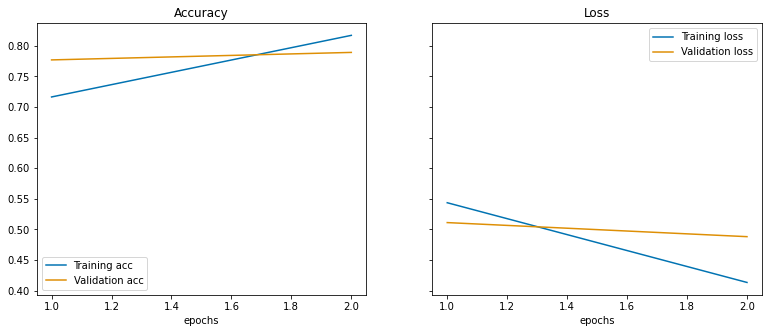

In [28]:
#print('Training Loss: %.3f' % (train_loss))
#print('Training Accuracy: %.3f' % (config.train_acc))


plot_training_history(history_dict = history, config=config)

# Test Set

### Load Data

In [29]:
docs_test = bioc_to_docs(test_dataset_path, config=config)
relevances_test = bioc_to_relevances(test_dataset_path, 'protein-protein')

x_test_df = docs_to_pandasdocs(docs_test)
y_test_df = relevances_to_pandas(x_test_df, relevances_test)

### Preprocessing

In [30]:
x_test, y_test = Bert_preprocessing(x_test_df, y_test_df, config,
                                    nmr_sentences=config.nmr_sentences)

### Predictions

In [31]:
config.model_id_path

PosixPath('../pipelines/models/biobert_lstm_ft/biobert_lstm_ft_55')

In [32]:
yhat_probs = model.predict(x_test, verbose=0)
yhat_probs = yhat_probs[:, 0]

yhat_classes = np.where(yhat_probs > 0.5, 1, yhat_probs)
yhat_classes = np.where(yhat_classes < 0.5, 0, yhat_classes).astype(np.int64)

### Evaluation

### ROC and Precision-Recall Curves

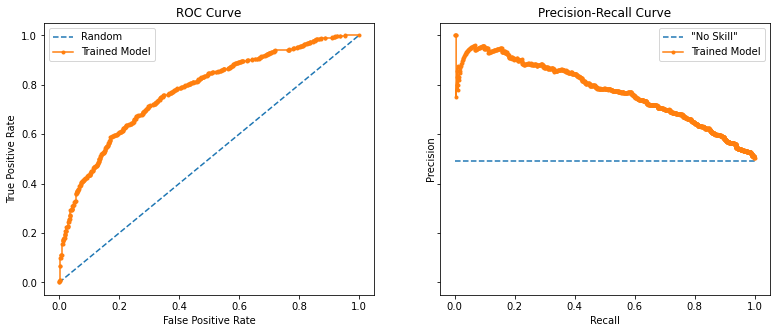

In [33]:
config.test_roc_auc, config.test_pr_auc = plot_roc_n_pr_curves(y_test, yhat_probs,config = config)

In [34]:
config.test_avg_prec  = average_precision(y_test_df, yhat_probs)
print('Average Precision: %f' % config.test_avg_prec)

# accuracy: (tp + tn) / (p + n)
config.test_acc = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % config.test_acc)

# precision tp / (tp + fp)
config.test_prec = precision_score(y_test, yhat_classes)
print('Precision: %f' % config.test_prec)

# recall: tp / (tp + fn)
config.test_recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % config.test_recall)

# f1: 2 tp / (2 tp + fp + fn)
config.test_f1_score = f1_score(y_test, yhat_classes)
print('F1 score: %f' % config.test_f1_score)

# ROC AUC
print('ROC AUC: %f' % config.test_roc_auc)

# PR AUC
print('PR AUC: %f' % config.test_pr_auc)

# kappa
config.test_kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % config.test_kappa)

config.test_mcc = matthews_corrcoef(y_test, yhat_classes)
print('MCC: %f' % config.test_mcc)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print('Confusion Matrix:\n %s \n' % matrix)

config.test_true_neg, config.test_false_pos, config.test_false_neg, config.test_true_pos = confusion_matrix(
                                                                                                y_test, yhat_classes).ravel()

Average Precision: 0.774368
Accuracy: 0.704975
Precision: 0.683053
Recall: 0.750000
F1 score: 0.714963
ROC AUC: 0.774079
PR AUC: 0.773924
Cohens kappa: 0.410605
MCC: 0.412535
Confusion Matrix:
 [[478 245]
 [176 528]] 



## Model ID

In [35]:
config.model_id

'biobert_lstm_ft_55'

## Save config

In [36]:
config.save()

In [37]:
config.path

PosixPath('../pipelines/models/biobert_lstm_ft/biobert_lstm_ft_55/config.txt')

## Write Results

In [38]:
config.write_report()

{'model_id': ['biobert_lstm_ft_55'], 'max_sent_len': [512], 'max_nb_words': [None], 'max_nb_sentences': [None], 'nmr_sentences': ['True'], 'embeddings': [None], 'embedding_dim': [None], 'embedding_format': [None], 'stop_words': ['No'], 'padding': ['post'], 'truncating': ['post'], 'oov_token': [None], 'lower': ['False'], 'remove_punctuation': ['False'], 'split_by_hyphen': ['False'], 'lemmatization': ['False'], 'stems': ['False'], 'seed_value': [42], 'epochs': [2], 'batch_size': [16], 'learning_rate': [3e-05], 'validation_percentage': [10], 'patience': [None], 'keras_callbacks': ['True'], 'train_acc': [None], 'train_f1_score': [None], 'test_avg_prec': [0.7743676277694067], 'test_acc': [0.7049754730203224], 'test_prec': [0.6830530401034929], 'test_recall': [0.75], 'test_f1_score': [0.7149627623561272], 'test_roc_auc': [0.7740789639129888], 'test_pr_auc': [0.773924088585553], 'test_kappa': [0.4106053693974756], 'test_mcc': [0.41253464145369445], 'test_true_neg': [478], 'test_false_pos': [2

### Model Save

In [ ]:
model.save(config.model_id_path / 'model_tf', save_format = 'tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(2*np.pi*300*t) + np.sin(2*np.pi*240*t)
Audio(audio_data, rate=framerate, autoplay=True)

In [ ]:
model.save_weights('test.h5')